In [82]:
import os 
from pathlib import Path
image_dir = Path(r"C:\Users\aryak\Downloads\archive")
main_folder = r"C:\Users\aryak\Downloads\archive"
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
print(os.listdir(main_folder))


['lfw-funneled', 'pairs.txt', 'pairsDevTest.txt', 'pairsDevTrain.txt']


# Data Preprocessing

In [83]:
import pandas as pd
def file_converter(file: str):
    '''
    df_triplets contains the main label data (name + start/end)

    df_quadruplets contains relation pairs (maybe similarity or match info)
    Takes in a file returning a formatted labelled data
    '''
    triplets = []
    quadruplets = []
    
    with open(file, 'r') as f:
        lines = f.readlines()
    
    for line in lines[1:]: 
        parts = line.strip().split()
    
        if len(parts) == 3:
            triplets.append(parts)
        elif len(parts) == 4:
            quadruplets.append(parts)
        else:
            print("Unexpected line:", line)
    df_triplets = pd.DataFrame(triplets, columns=["name", "start", "end"])
    df_quadruplets = pd.DataFrame(quadruplets, columns=["name1", "val1", "name2", "val2"])
    

    df_triplets[["start", "end"]] = df_triplets[["start", "end"]].astype(int)
    df_quadruplets[["val1", "val2"]] = df_quadruplets[["val1", "val2"]].astype(int)
    return df_triplets, df_quadruplets

    
    print("Triplets shape:", df_triplets.shape)
    print("Quadruplets shape:", df_quadruplets.shape)
    
train_msg = "C:/Users/aryak/Downloads/archive/pairsDevTrain.txt"
trainfile_converter = file_converter(train_msg)
df_triplets_train,  df_quadruplets_train= trainfile_converter

test_Msg = "C:/Users/aryak/Downloads/archive/pairsDevTest.txt" 
testfile_converter = file_converter(train_msg)
df_triplets_test,  df_quadruplets_test= testfile_converter

print(df_triplets_train)
df_quadruplets_train


                     name  start  end
0           Aaron_Peirsol      1    2
1           Aaron_Peirsol      3    4
2            Aaron_Sorkin      1    2
3     Abdel_Nasser_Assidi      1    2
4                Abdullah      1    3
...                   ...    ...  ...
1095           Zhu_Rongji      1    9
1096           Zhu_Rongji      4    7
1097           Zhu_Rongji      4    8
1098           Zhu_Rongji      5    6
1099      Zinedine_Zidane      2    4

[1100 rows x 3 columns]


,name1,val1,name2,val2
0,AJ_Cook,1,Marsha_Thomason,1
1,Aaron_Sorkin,2,Frank_Solich,5
2,Abdel_Nasser_Assidi,2,Hilary_McKay,1
3,Abdoulaye_Wade,4,Linda_Dano,1
4,Abdul_Rahman,1,Magui_Serna,1
...,...,...,...,...
1095,Tom_Vilsack,1,Wayne_Ferreira,5
1096,Trisha_Meili,1,Vladimiro_Montesinos,3
1097,Ty_Votaw,1,Wayne_Allard,1
1098,Vytas_Danelius,1,Zaini_Abdullah,1


In [84]:
from pathlib import Path
img_root = Path(r"C:\Users\aryak\Downloads\archive\lfw-funneled\lfw_funneled")

def build_image_path(name, index):
    filename = f"{name}_{int(index):04d}.jpg"
    return img_root / name / filename

def find_positive_pair_cutoff(df):
    for i, row in df.iterrows():
        if row["name1"] != row["name2"]:
            return i
    return len(df) 


N = find_positive_pair_cutoff(df_quadruplets_train)



df_quadruplets_train["label"] = [1]*N + [0]*(len(df_quadruplets_train) - N)
df_quadruplets_train["path1"] = df_quadruplets_train.apply(lambda row: build_image_path(row["name1"], row["val1"]), axis=1)
df_quadruplets_train["path2"] = df_quadruplets_train.apply(lambda row: build_image_path(row["name2"], row["val2"]), axis=1)

df_triplets_train["path1"] = df_triplets_train.apply(lambda row: build_image_path(row["name"], row["start"]), axis=1)
df_triplets_train["path2"] = df_triplets_train.apply(lambda row: build_image_path(row["name"], row["end"]), axis=1)
df_triplets_train["label"] = 1 

df_all_pairs = pd.concat([
    df_triplets_train[["path1", "path2", "label"]],
    df_quadruplets_train[["path1", "path2", "label"]]
], ignore_index=True)



In [85]:
df_all_pairs["valid_paths"] = df_all_pairs.apply(
    lambda row: os.path.exists(row["path1"]) and os.path.exists(row["path2"]),
    axis=1
)


df_all_pairs = df_all_pairs[df_all_pairs["valid_paths"]].drop(columns=["valid_paths"]).reset_index(drop=True)




In [86]:
df_all_pairs.sample(1).to_dict()

{'path1': {1143: WindowsPath('C:/Users/aryak/Downloads/archive/lfw-funneled/lfw_funneled/Aldo_Paredes/Aldo_Paredes_0001.jpg')},
 'path2': {1143: WindowsPath('C:/Users/aryak/Downloads/archive/lfw-funneled/lfw_funneled/Azmi_Bishara/Azmi_Bishara_0001.jpg')},
 'label': {1143: 0}}

# Identifying 2 whether 2 people are the same

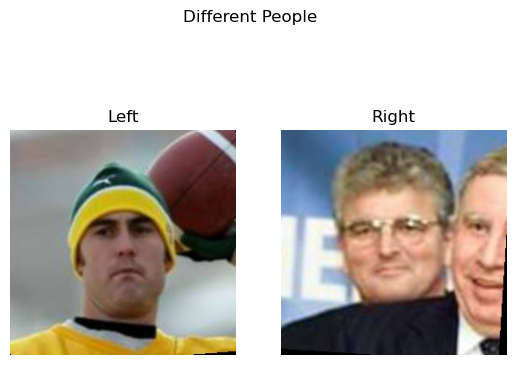

In [87]:
from PIL import Image

def show_random_pair(df):
    '''
    Identifies whether 2 images are the same person or not, printing 'same person' and 'different people' respectfully
    Takes in the preprocessed dataframe returning nothing but displaying the 2 images aas well as whether they are the same person or not
    '''
    
    sample = df.sample(1).iloc[0]
    img1 = Image.open(sample["path1"])
    img2 = Image.open(sample["path2"])
    
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(img1); axes[0].axis('off'); axes[0].set_title("Left")
    axes[1].imshow(img2); axes[1].axis('off'); axes[1].set_title("Right")
    plt.suptitle("Same Person" if sample["label"] == 1 else "Different People")
    plt.show()


show_random_pair(df_all_pairs)

In [88]:
from pathlib import Path
import pandas as pd

img_root = Path(r"C:\Users\aryak\Downloads\archive\lfw-funneled\lfw_funneled")

data = []
for person_dir in img_root.iterdir():
    if person_dir.is_dir():
        for img_path in person_dir.glob("*.jpg"):
            data.append({"path": str(img_path), "label": person_dir.name})

df_faces = pd.DataFrame(data)
print(df_faces.head())

                                                path            label
0  C:\Users\aryak\Downloads\archive\lfw-funneled\...    Aaron_Eckhart
1  C:\Users\aryak\Downloads\archive\lfw-funneled\...      Aaron_Guiel
2  C:\Users\aryak\Downloads\archive\lfw-funneled\...  Aaron_Patterson
3  C:\Users\aryak\Downloads\archive\lfw-funneled\...    Aaron_Peirsol
4  C:\Users\aryak\Downloads\archive\lfw-funneled\...    Aaron_Peirsol


In [89]:
image_counts = df_faces["label"].value_counts()

balanced_people = image_counts[(image_counts >= 4) & (image_counts <= 15)].index


df_faces_balanced = df_faces[df_faces["label"].isin(balanced_people)].reset_index(drop=True)


In [90]:
print(df_faces_balanced["label"].value_counts())

label
Taha_Yassin_Ramadan          15
Bill_Simon                   15
Norah_Jones                  15
Meryl_Streep                 15
Dominique_de_Villepin        15
                             ..
Kate_Winslet                  4
Katherine_Harris              4
Kathleen_Kennedy_Townsend     4
Kim_Jong-Il                   4
Zoran_Djindjic                4
Name: count, Length: 526, dtype: int64


In [91]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
    df_faces_balanced,
    test_size=0.2,
    stratify=df_faces_balanced["label"],
    random_state=42
)


# Building a model to identify a newly added person

In [92]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_gen = datagen.flow_from_dataframe(
    train_df,
    x_col="path",
    y_col="label",
    target_size=(100, 100),
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    subset="training"
)

val_gen = datagen.flow_from_dataframe(
    train_df,
    x_col="path",
    y_col="label",
    target_size=(100, 100),
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    subset="validation"
)


Found 2117 validated image filenames belonging to 526 classes.
Found 529 validated image filenames belonging to 526 classes.


In [93]:
from tensorflow.keras import layers, models
num_classes = len(train_gen.class_indices)
model = models.Sequential([
    layers.Input(shape=(100, 100, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_13 (Conv2D)              │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 33856)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │     4,333,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 526)            │        67,854 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,420,942 (16.86 MB)

 Trainable params: 4,420,942 (16.86 MB)

 Non-trainable params: 0 (0.00 B)

In [94]:
history = model.fit(train_gen, validation_data=val_gen, epochs=10)
from tensorflow.keras.preprocessing import image
import numpy as np

def predict_person(img_path):
    '''
    Predicting a person from an image passed and returning the neccessary class labels 
    '''
    img = image.load_img(img_path, target_size=(100, 100))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    pred = model.predict(img_array)
    class_index = np.argmax(pred)
    class_label = train_gen.class_indices
    inv_class_labels = {v: k for k, v in class_label.items()}
    return inv_class_labels[class_index]





Epoch 1/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - accuracy: 9.2359e-04 - loss: 6.2889 - val_accuracy: 0.0000e+00 - val_loss: 6.2661
Epoch 2/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.0046 - loss: 6.2217 - val_accuracy: 0.0038 - val_loss: 6.2879
Epoch 3/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.0359 - loss: 5.9459 - val_accuracy: 0.0265 - val_loss: 6.4342
Epoch 4/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.2142 - loss: 4.3791 - val_accuracy: 0.0529 - val_loss: 6.8644
Epoch 5/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.6905 - loss: 1.5616 - val_accuracy: 0.0454 - val_loss: 9.6359
Epoch 6/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.9472 - loss: 0.2465 - val_accuracy: 0.0416 - val_loss: 11.5732
Epoch 7/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.9940 - loss: 0.0351 - val_accuracy: 0.0416 - val_loss: 12.5108
Epoch 8/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.9993 - loss: 0.0089 - val_accuracy: 

In [95]:
import matplotlib.pyplot as plt

def plot_training_metrics(history):
    '''
    takes in the fitted CNN, returning nothing but creating a loss and accuracy graph
    '''
    plt.figure(figsize=(10, 4))


    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="train acc")
    plt.plot(history.history["val_accuracy"], label="val acc")
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()


    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="train loss")
    plt.plot(history.history["val_loss"], label="val loss")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()


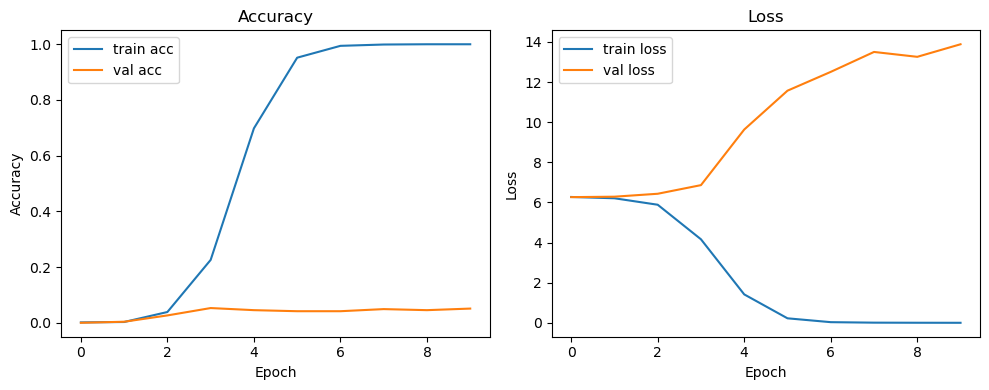

In [96]:
plot_training_metrics(history)

In [97]:
def predict_person(img_path, model, class_indices, target_size=(100, 100)):
    from tensorflow.keras.preprocessing import image
    import numpy as np

    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    pred = model.predict(img_array)
    class_index = np.argmax(pred[0])
    inv_class_indices = {v: k for k, v in class_indices.items()}
    predicted_label = inv_class_indices[class_index]
    confidence = pred[0][class_index]
    return predicted_label, confidence

In [98]:
test_image = r"C:\Users\aryak\Downloads\archive\lfw-funneled\lfw_funneled\Elizabeth_Hurley\Elizabeth_Hurley_0003.jpg"
name, conf = predict_person(test_image, model, train_gen.class_indices)
print(f"Predicted: {name} (Confidence: {conf:.2f})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Predicted: Elizabeth_Hurley (Confidence: 1.00)


In [99]:
import cv2

def capture_face_from_camera(save_path="temp.jpg"):
    cam = cv2.VideoCapture(0)
    print("Press SPACE to capture your face, ESC to exit.")

    while True:
        ret, frame = cam.read()
        if not ret:
            print("Failed to grab frame.")
            break
        cv2.imshow("Camera", frame)

        k = cv2.waitKey(1)
        if k % 256 == 27: 
            print("Closing camera.")
            break
        elif k % 256 == 32:  
            cv2.imwrite(save_path, frame)
            print(f"Image saved to {save_path}")
            break

    cam.release()
    cv2.destroyAllWindows()
    return save_path

In [100]:
def access_control(model, class_indices, known_name="Aryak", threshold=0.7):
    img_path = capture_face_from_camera()

    predicted_name, confidence = predict_person(img_path, model, class_indices)

    if predicted_name == known_name and confidence >= threshold:
        print(f"Hey there, {predicted_name}!")
    else:
        print(f"I unfortunately dont know who you are. Try putting 5 images of yourself into a folder and placing in the right directory")


In [101]:
capture_face_from_camera("Aryak_0005.jpg")

Press SPACE to capture your face, ESC to exit.
Image saved to Aryak_0005.jpg


'Aryak_0005.jpg'

In [102]:
img_path = r"C:\Users\aryak\Downloads\archive\lfw-funneled\lfw_funneled\Aryak\Aryak_0004.jpg"
name, conf = predict_person(img_path, model, train_gen.class_indices)
print(f"Predicted: {name} (Confidence: {conf:.2f})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted: Aryak (Confidence: 1.00)


### Note: AI assistance was used for naming and debugging
